<a href="https://colab.research.google.com/github/Chandrachapa/C_learning/blob/master/ellipse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install quadprog

In [ ]:
pip install SimpleITK 

     |████████████████████████████████| 47.4MB 84kB/s 


In [7]:
pip install gap-stat

In [3]:
pip install gapstat_rs

     |████████████████████████████████| 819kB 7.6MB/s 


d:  [2 3]
Optimal value: 0.3612016034168673


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


centroids 2d:  [[ 9.99879706e-01  1.00056242e+00]
 [-9.13942481e-04  9.99922505e-01]
 [ 1.50116693e+00  1.50196406e+00]]
Optimal clusters:  7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


silhouette_score kmeans 0.31212706948865737


<Figure size 432x288 with 0 Axes>

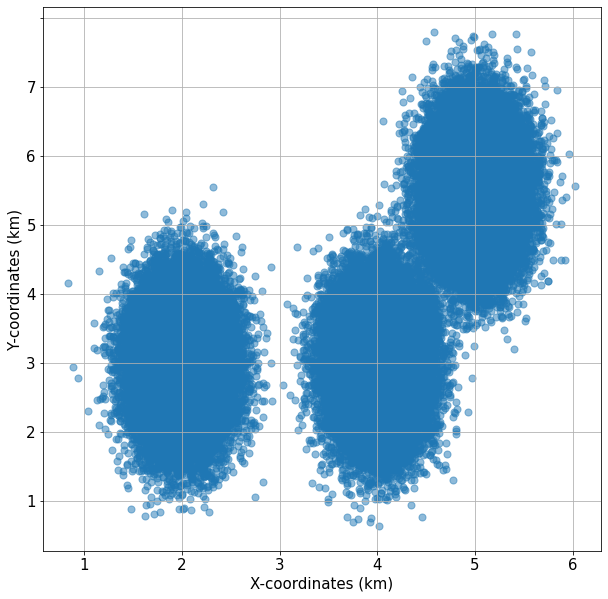

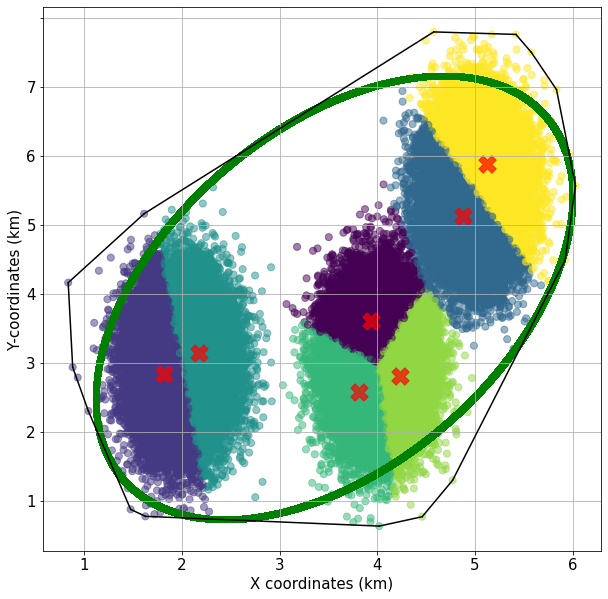

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:147: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


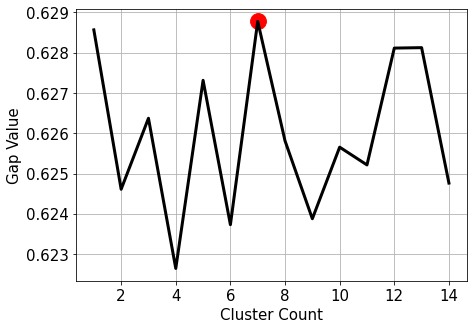

closest points to centroids in n clusters :  [62010 22066 23897]
inside no:  84160
inside points:  (84160, 2)
outside no:  15840
new cluster count:  13
silhouette_score ellipsoid 0.33093496681333917


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:273: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


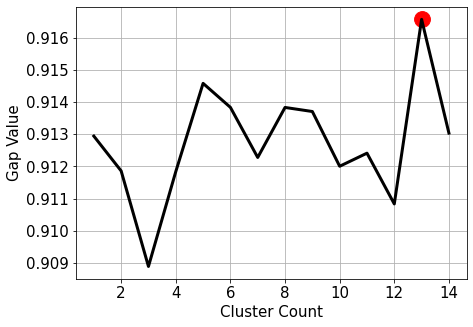

In [202]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_blobs
from collections import Counter
import math
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.decomposition import PCA
from gap_statistic import OptimalK
from numpy import linalg as LA

np.random.seed(0)

#https://stackoverflow.com/questions/61859098/maximum-volume-inscribed-ellipsoid-in-a-polytope-set-of-points?fbclid=IwAR2DcaQSvqd368lstBayY-atAbQxCVa_EecgS7HE-mrpK6EanO9qbsX2Drg
#From: https://stackoverflow.com/a/61786434/752843
def random_point_ellipsoid(a,b,c,x0,y0,z0):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    u = np.random.rand()
    v = np.random.rand()
    theta = u * 2.0 * np.pi
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return rx, ry, rz

def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Npts):
  if dims==2:
    np.random.seed(0)
    W = sklearn.datasets.make_spd_matrix(2)
    d = np.array([2,3])
    print("d: ",d)
    #form clusters 2d 
    centers = [[0, 1], [1.5, 1.5], [1,1]]
    stds = [0.12, 0.12, 0.12]
    points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)
    #mycolours = ["red", "green", "blue"]
    #col = [mycolours[i] for i in labels_true]
    #points = np.array([random_point_ellipse(W,d) for i in range(Npts)])
    #print("points: ",points)
  elif dims==3:
    #form clusters 3d
    centers = [[0, 1000, 0], [1500, 1500, 1000], [1000, 3000, 3000]]
    stds = [0.5, 0.5, 0.5]
    points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)
    mycolours = ["red", "green", "blue"]
    col = [mycolours[i] for i in labels_true]
    #points = np.array([random_point_ellipsoid(3,5,7,2,3,3) for i in range(Npts)])
    #print("3d points: ",points)
  else:
    raise Exception("dims must be 2 or 3!")
  noise = np.random.multivariate_normal(mean=[0]*dims, cov=0.2*np.eye(dims), size=Npts)
  return points

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def Plot(points, hull, B, d):
  fig = plt.figure()
  if points.shape[1]==2:
    np.random.seed(0)
    #kmeans_model = KMeans(n_clusters=K).fit(points)
    kmeans_model = KMeans(n_clusters=3,init='k-means++', n_init=10)
    kmeans = kmeans_model.fit(points)
    centers = np.array(kmeans.cluster_centers_)
    fig = plt.figure(figsize = (10, 10)) 
    plt.grid(True)
    ax = fig.add_subplot(111)
    #mycolours = ["red", "green", "blue"]
    #col = [mycolours[i] for i in labels_true]
    ax.scatter(points[:,0], points[:,1],s=50,alpha=0.5)
    #ax.scatter(points[:,0], points[:,1],c=kmeans.labels_.astype(float),s=50,cmap='viridis',alpha=0.5)
    #ax.scatter(centers[:,0], centers[:,1], c = 'r', marker ='X',s=300,alpha=1) 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids 2d: ",centroids)
    #for simplex in hull.simplices:
      #plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(100000)])
    display_points = display_points@B+d
    #ax.scatter(display_points[:,0], display_points[:,1],c='green',alpha=0.7)
    #ax.set_ylim(-0.6,3.0)
   # ax.set_xlim(-1.5,3.2)
    ax.set_xticklabels([0,1,2,3,4,5,6],fontsize=15)
    ax.set_yticklabels([0,1,2,3,4,5,6,7],fontsize=15)
    ax.set_xlabel('X-coordinates (km)',fontsize=15)
    ax.set_ylabel('Y-coordinates (km)',fontsize=15)
    
    #optimal clustering
    np.random.seed(0)
    optimalK = OptimalK(parallel_backend='rust')
    n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
    print('Optimal clusters: ', n_clusters)

    #plot
    fig = plt.figure(figsize = (10, 10)) 
    plt.grid(True)
    ax1 = fig.add_subplot(111)
    #n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
    #print('Optimal clusters: ', n_clusters)
    np.random.seed(42)
    optimalK.gap_df.head()
    km = KMeans(n_clusters,init='k-means++', n_init=10)
    km.fit(points)
    y_cluster_kmeans = km.predict(points)
    #score kmeans 
    #score = adjusted_rand_score(labels_true, y_cluster_kmeans)
    #print("score kmeans: ",score)
    score2 = metrics.silhouette_score(points, y_cluster_kmeans)
    print("silhouette_score kmeans",score2)

    ax1.scatter(points[:,0], points[:,1],c=km.labels_.astype(float),s=50,cmap='viridis',alpha=0.5)
    plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r',marker ='X', s=300, alpha=0.7)
    for simplex in hull.simplices:
      plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    ax1.scatter(display_points[:,0], display_points[:,1],c='green',alpha=0.7)
    ax1.set_xticklabels([0,1,2,3,4,5,6],fontsize=15)
    ax1.set_yticklabels([0,1,2,3,4,5,6,7],fontsize=15)
    ax1.set_xlabel('X coordinates (km)',fontsize=15)
    ax1.set_ylabel('Y-coordinates (km)',fontsize=15)
    plt.show()

    #plot
    fig = plt.figure(figsize = (7, 5)) 
    ax1 = fig.add_subplot(111)
    ax = plt.subplot(111,)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
             item.set_fontsize(15)
    plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
    plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
                optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
    plt.grid(True)
    plt.xlabel('Cluster Count',fontsize=15)
    plt.ylabel('Gap Value',fontsize=15)
    #plt.title('Gap Values by Cluster Count')
    plt.show()

  elif points.shape[1]==3:
    #from:https://pythonprogramminglanguage.com/kmeans-clustering-centroid/
    kmeans_model = KMeans(n_clusters=3, random_state=0, max_iter=100000, init='k-means++', n_init=10)
    kmeans = kmeans_model.fit(points)
    centers = np.array(kmeans.cluster_centers_)
    #centers = mean_finder()
    fig = plt.figure(figsize = (15, 10)) 
    ax = fig.add_subplot(111, projection='3d')
    mycolours = ["red", "green", "blue"]
    col = [mycolours[i] for i in labels_true]
    ax.scatter(points[:,0], points[:,1], points[:,2],c= kmeans.labels_.astype(float),s=50,cmap=col,alpha=0.1,label='Inline label')
    ax.scatter(centers[:,0], centers[:,1],centers[:,2], c = 'r', marker ='X',s=100,alpha=1) 
    # Centroid coordinates
    centroids = kmeans.cluster_centers_
    print("centroids 3d: ",centroids)
    #convex hull for 3d
    #for simplex in hull.simplices:
     #plt.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2],'k-')
    display_points = np.array([random_point_ellipsoid(1,1,1,0,0,0) for i in range(100000)])
    #display_points = points
    display_points = display_points@B+d
    #ax.scatter(display_points[:,0], display_points[:,1], display_points[:,2],alpha=0.1)
  plt.show()


def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  Plot(points, hull, B.value, d.value)
  #print("B : ",B.value)  
  #print("d: ",d.value)
  return B.value, d.value

FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Npts=100000))
#FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=3, Npts=1000))

centers = [[0, 1, 0], [1.5, 1.5, 1], [1, 1, 1]]
stds = [0.2, 0.12, 0.12]
points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)
#data point closest to the centroid of cluster
#from:https://stackoverflow.com/questions/57083134/scikit-k-means-find-data-points-that-belong-to-resulting-cluster-of-specific-ce
km = KMeans(n_clusters=3,init='k-means++', n_init=10).fit(points)
closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, points)
#nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(points)
print("closest points to centroids in n clusters : ",closest) 

#optimal clustering using points inside only
from numpy.linalg import multi_dot
np.random.seed(0)
outside=0
inside=0
centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.12, 0.12, 0.12]
points, labels_true = make_blobs(n_samples=100000,centers=centers, cluster_std=stds, random_state=0)
#print("labels_true: ",labels_true)
result_t = []
label_t = []

# Impose the constraint that v₁, ..., vₙ are all outside of the ellipsoid.

for i in range(100000):
  P = (points[i] - d).T         
  Q = (np.linalg.inv(B)).T
  R = np.linalg.inv(B)
  S = (points[i] - d)
  
  if multi_dot([P,Q,R,S])> 1:
          inside =inside+1
          #result_t = np.hstack((result_t, points[i]))
          np.array(result_t.append(points[i]))
          np.array(label_t.append(labels_true[i]))
  elif multi_dot([P,Q,R,S])<= 1:
          outside =outside+1
          #np.array(label_t.append('0'))

print("inside no: ",inside)   
print("inside points: ",np.array(result_t).shape)
print("outside no: ",outside)  

optimalK = OptimalK(parallel_backend='rust')
n_clusters2 = optimalK(np.array(result_t), cluster_array=range(1, 15))
print("new cluster count: ",n_clusters2)

optimalK.gap_df.head()
km = KMeans(n_clusters2,init='k-means++', n_init=10)
km.fit(np.array(result_t))
ellipsoid_labels=km.predict(np.array(result_t))
#print("y_cluster: ", y_cluster)

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn import metrics
#score = adjusted_rand_score(np.array(label_t), ellipsoid_labels)
#print("score: ",score)

score = metrics.silhouette_score(np.array(result_t), ellipsoid_labels)
print("silhouette_score ellipsoid",score)


#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
ax = plt.subplot(111,)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()


In [153]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = GaussianMixture(n_components=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.predict(X)

# Make some data
np.random.seed(0)
centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.12, 0.12, 0.12]
points, labels_true = make_blobs(n_samples=100000, centers=centers, cluster_std=stds, random_state=0)

# Define the OptimalK instance, but pass in our own clustering function
optimalk = OptimalK(clusterer=special_clustering_func)

# Use the callable instance as normal.
n_clusters2 = optimalk(points, cluster_array=range(1, 15))

print("new cluster count: ",n_clusters2)

optimalK.gap_df.head()


#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
ax = plt.subplot(111,)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

ValueError: ignored

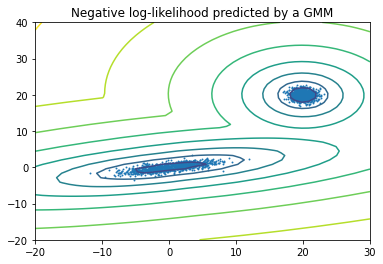

In [7]:
#density estimation in clusters
#from: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#sphx-glr-auto-examples-mixture-plot-gmm-pdf-py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 1000

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=3, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))

plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Data shape:  (1000, 2)
Optimal clusters:  2


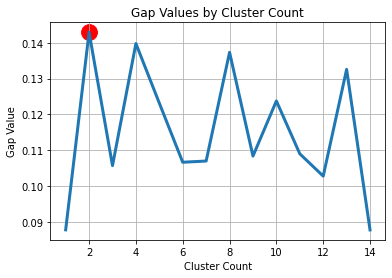

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


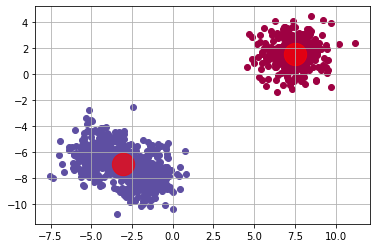

In [10]:
#from : https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb
#gap statistics


%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
try:
    from sklearn.datasets.samples_generator import make_blobs
except ImportError:
    from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#np.random.seed(0)
optimalK = OptimalK(parallel_backend='rust')

X, y = make_blobs(n_samples=int(1e3), n_features=2, centers=3, random_state=25)
print('Data shape: ', X.shape)

n_clusters = optimalK(X, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

optimalK.gap_df.head()

#plot
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()


# Now that we have the optimal clusters, n, we build our own KMeans model...
km = KMeans(n_clusters)
km.fit(X)

df = pd.DataFrame(X, columns=['x','y'])
df['label'] = km.labels_

colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))

for color, label in zip(colors, df.label.unique()):
    
    tempdf = df[df.label == label]
    plt.scatter(tempdf.x, tempdf.y, c=color)
    
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r', s=500, alpha=0.7, )
plt.grid(True)
plt.show()

Optimal clusters:  10


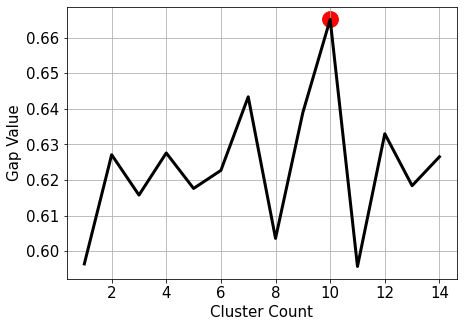

no  clusters meanshift:  1


AttributeError: ignored

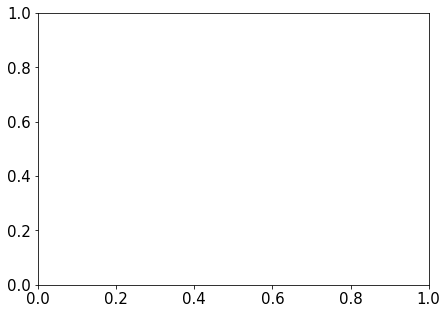

In [41]:
#from : https://github.com/milesgranger/gap_statistic/blob/master/Example.ipynb
#meanshift

# We'll wrap the `MeanShift` algorithm from sklearn

from sklearn.cluster import MeanShift

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = MeanShift()
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

def special_clustering_func_2(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = KMeans(k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

# Make some data
centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.2, 0.2, 0.2]
points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

#optimal clustering
np.random.seed(0)
optimalK = OptimalK(parallel_backend='rust')
n_clusters = optimalK(points, cluster_array=range(1, 15))
print('Optimal clusters: ', n_clusters)

#plot
#n_clusters = optimalK(points, cluster_array=np.arange(1, 15))
np.random.seed(0)
optimalK.gap_df.head()

#plot
fig = plt.figure(figsize = (7, 5)) 
ax = fig.add_subplot(111)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
          ax.get_xticklabels() + ax.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3, color="black")
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

# Define the OptimalK instance, but pass in our own clustering function
optimalk2 = OptimalK(clusterer=special_clustering_func)

# Use the callable instance as normal.
n_clusters2 = optimalk2(points, cluster_array=range(1, 15))

print("no  clusters meanshift: ",n_clusters2)

#plot
fig = plt.figure(figsize = (7, 5)) 
ax1 = fig.add_subplot(111)
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
          ax1.get_xticklabels() + ax1.get_yticklabels()):
          item.set_fontsize(15)
plt.plot(optimalK.gap_df.n_clusters2, optimalK.gap_df.gap_value, linewidth=3, color="black")
#plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters2 == n_clusters2].n_clusters2,
            #optimalK.gap_df[optimalK.gap_df.n_clusters2 == n_clusters2].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count',fontsize=15)
plt.ylabel('Gap Value',fontsize=15)
#plt.title('Gap Values by Cluster Count')
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


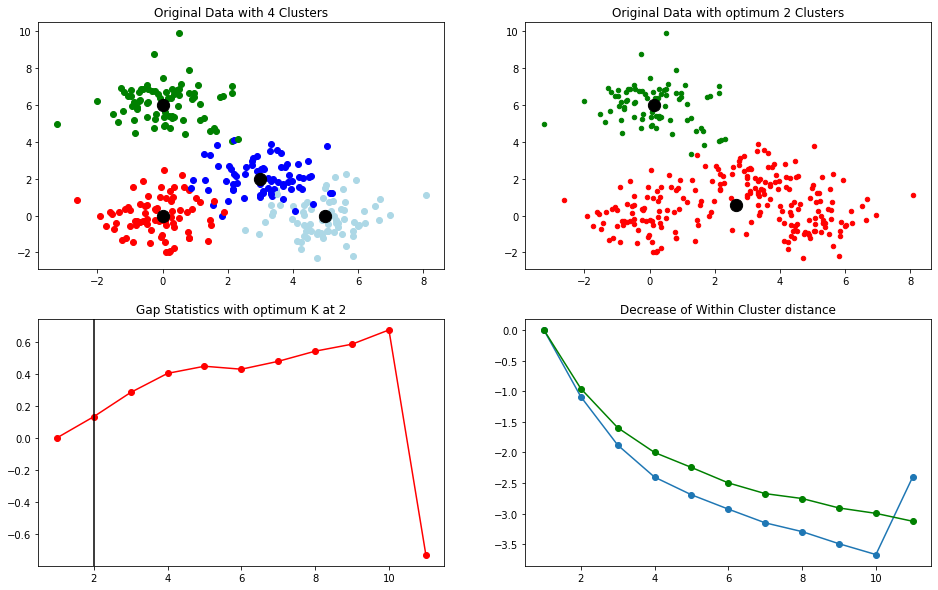

In [ ]:
#from : https://github.com/Mavengence/Pattern_Analysis_SS20_FAU/blob/master/Exercise_6.ipynb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from scipy.ndimage.interpolation import shift
import scipy
from IPython.display import Image
import seaborn as sns

np.random.seed(0)

def kmeans(num_centers, X):
    centers = np.random.uniform(np.min(X[0]), np.max(X[0]), size=(num_centers, 2))
    
    for _ in range(10):

        assigned_to_clusters = np.zeros(len(X))

        for i, x in enumerate(X):
            closest_center = np.argmin([np.linalg.norm(x - center) for center in centers]) 
            assigned_to_clusters[i] = closest_center

        new_centers = np.array([np.mean(X[assigned_to_clusters == i], axis=0) for i in range(num_centers)])    
        convergence = np.sum(np.abs(new_centers - centers))
        centers = new_centers
    
    return np.array(new_centers), np.array(assigned_to_clusters)

def calculate_Wk(Ks, input_data):
    e = np.finfo(float).eps
    if(len(input_data) == 2):
        X = input_data[0]
        label = input_data[1]
    else:
        X = input_data
    
    Ks = np.arange(1,Ks+1)
    within_cluster_dists = []
    
    for K in Ks:

        dists = 0
        centroids, points = kmeans(K, X)

        for i in range(K):
            cluster_array = X[points == i]
            centroid_dist = [] 
            dist = 0

            if len(cluster_array) > 0:
                for j in range(len(cluster_array)):
                    centroid_dist.append(np.linalg.norm(centroids[i] - cluster_array[j]))

            dist += np.sum(centroid_dist)
            dists += dist + e

        within_cluster_dists.append(np.log(((dists + e) / K)))
        
        normalized_wcd = within_cluster_dists - np.max(within_cluster_dists)
    
    return normalized_wcd


def simulate(iterations, K):
    e = np.finfo(float).eps
    simulated_Wk = np.zeros((iterations, K)) + e 
    simulated_sk = np.zeros((iterations, K)) + e
    
    for i in range(iterations):
        
        temp_wk = []
        temp_sk = []
        
        X = np.random.uniform(0, 1, size=(300, 2))
        
        within_cluster_dists = calculate_Wk(K, X)
                    
        simulated_Wk[i] = within_cluster_dists
        
    Wks = np.mean(simulated_Wk + e, axis=0)
    sks = np.std(simulated_Wk + e, axis=0) * np.sqrt(1 + 1/20)
    
    
    return Wks, sks


def shift_to_one(shift, to_range):
    shifted = np.zeros(to_range)
    shifted[1:] = shift
    shifted[0] = np.nan 
    return shifted


def start_gap_statistics(simulations, Ks, input_data, input_centers):
    
    if(len(input_data) == 2):
        data = input_data[0]
        label = input_data[1]
    else:
        data = input_data
        
    colors = {0: "red", 1: "green", 2: 'blue', 3:'lightblue', 4:'yellow', 5:'pink', 6:'orange', 7:'purple',
         8:'magenta'}
    
    Wks, sks = simulate(simulations, Ks)
    within_cluster_dists = calculate_Wk(Ks, data)
    G = Wks - within_cluster_dists
    
    shifted_wks = shift_to_one(Wks, Ks+1)
    shifted_sks = shift_to_one(sks, Ks+1)
    shifted_g = shift_to_one(G, Ks+1)
    shifted_wcd = shift_to_one(within_cluster_dists, Ks+1)
    
    
    optimum = 0
    
    # THE GAP STATISTICS FORMULA FROM THE SCRIPT
    for i in range(0, len(G) - 1):
        if(G[i] >= G[i+1] - sks[i+1]):
            optimum = i
            break
    
    if optimum == 0:
        optimum = 1
        
    plt.figure(figsize=(16,10))
    
    mapped_colors = [colors[i] for i in label]
    
    # Top Left
    plt.subplot(2, 2, 1)       
    for i, x in enumerate(data):
        plt.scatter(x[0], x[1], color=mapped_colors[i], cmap='rainbow')
    
    for j in range(len(input_centers)):
        plt.scatter(input_centers[j][0], input_centers[j][1], color="black", s=150)
    
    plt.title("Original Data with {} Clusters".format(len(input_centers)))
    
    # Bottom right
    plt.subplot(2, 2, 4)        
    plt.plot(shifted_wcd, '-o', label="Drawn from Data")
    plt.plot(shifted_wks, '-o', color="green", label="Simulated")
    plt.title("Decrease of Within Cluster distance")
    
    # Bottom left
    plt.subplot(2, 2, 3)       
    plt.plot(shifted_g, '-o', color='r')
    plt.axvline(x=optimum, color='black')
    plt.title("Gap Statistics with optimum K at {}".format(optimum))
    
    # Top right    
    plt.subplot(2, 2, 2) 
    center_points, center_arrays = kmeans(optimum, data)
    centers = center_points
    color_array = center_arrays
    color = np.array([colors[x] for x in color_array])
      
    for j in range(optimum):

        points = data[color == colors[j]]
        c = colors[j]

        plt.scatter(points[:,0], points[:,1], color=c, s=20)
        plt.scatter(centers[j][0], centers[j][1], color="black", s=150)
        plt.title("Original Data with optimum {} Clusters".format(optimum))
      
    plt.show()

centers = [[0,0], [0,6], [3,2], [5,0]]
data = make_blobs(n_samples=300, centers=centers, n_features=2, cluster_std=1)

start_gap_statistics(20, 11, data, centers)

Automatically created module for IPython interactive environment


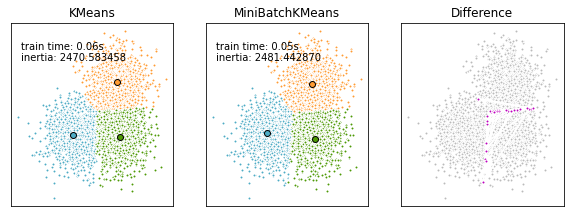

In [ ]:
#from: https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html#sphx-glr-auto-examples-cluster-plot-mini-batch-kmeans-py

print(__doc__)

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

# #############################################################################
# Generate sample data
np.random.seed(0)

batch_size = 45
centers = [[1, 1], [-1, -1], [1, -1]]
n_clusters = len(centers)
X, labels_true = make_blobs(n_samples=3000, centers=centers, cluster_std=0.7)

# #############################################################################
# Compute clustering with Means

k_means = KMeans(init='k-means++', n_clusters=3, n_init=10)
t0 = time.time()
k_means.fit(X)
t_batch = time.time() - t0

# #############################################################################
# Compute clustering with MiniBatchKMeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=batch_size,
                      n_init=10, max_no_improvement=10, verbose=0)
t0 = time.time()
mbk.fit(X)
t_mini_batch = time.time() - t0

# #############################################################################
# Plot result

fig = plt.figure(figsize=(8, 3))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)
colors = ['#4EACC5', '#FF9C34', '#4E9A06']

# We want to have the same colors for the same cluster from the
# MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per
# closest one.
k_means_cluster_centers = k_means.cluster_centers_
order = pairwise_distances_argmin(k_means.cluster_centers_,
                                  mbk.cluster_centers_)
mbk_means_cluster_centers = mbk.cluster_centers_[order]

k_means_labels = pairwise_distances_argmin(X, k_means_cluster_centers)
mbk_means_labels = pairwise_distances_argmin(X, mbk_means_cluster_centers)

# KMeans
ax = fig.add_subplot(1, 3, 1)
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('KMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8,  'train time: %.2fs\ninertia: %f' % (
    t_batch, k_means.inertia_))

# MiniBatchKMeans
ax = fig.add_subplot(1, 3, 2)
for k, col in zip(range(n_clusters), colors):
    my_members = mbk_means_labels == k
    cluster_center = mbk_means_cluster_centers[k]
    ax.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
ax.set_title('MiniBatchKMeans')
ax.set_xticks(())
ax.set_yticks(())
plt.text(-3.5, 1.8, 'train time: %.2fs\ninertia: %f' %
         (t_mini_batch, mbk.inertia_))

# Initialise the different array to all False
different = (mbk_means_labels == 4)
ax = fig.add_subplot(1, 3, 3)

for k in range(n_clusters):
    different += ((k_means_labels == k) != (mbk_means_labels == k))

identic = np.logical_not(different)
ax.plot(X[identic, 0], X[identic, 1], 'w',
        markerfacecolor='#bbbbbb', marker='.')
ax.plot(X[different, 0], X[different, 1], 'w',
        markerfacecolor='m', marker='.')
ax.set_title('Difference')
ax.set_xticks(())
ax.set_yticks(())

plt.show()

Optimal value: 0.1875847184458806


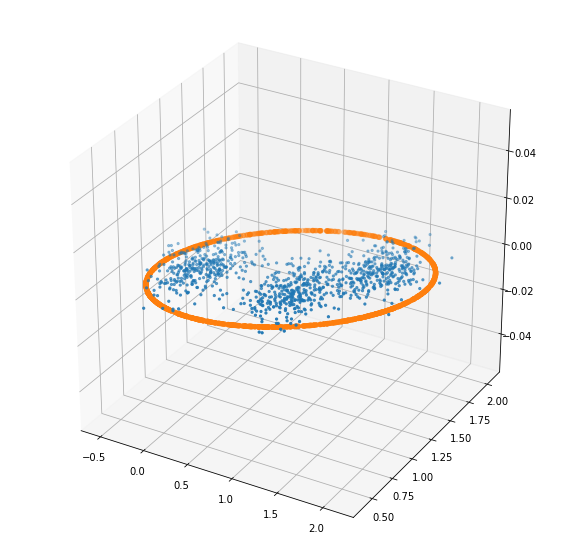

Ellipsoid Volume:  3.4729565846416772


In [ ]:
from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn.datasets
import SimpleITK as sitk
import code



def get_volume_ml(image):
    x_spacing, y_spacing, z_spacing = image.GetSpacing()
    image_nda = sitk.GetArrayFromImage(image)
    imageSegm_nda_NonZero = image_nda.nonzero()
    num_voxels = len(list(zip(imageSegm_nda_NonZero[0],
                              imageSegm_nda_NonZero[1],
                              imageSegm_nda_NonZero[2])))
    if 0 >= num_voxels:
        print('The mask image does not seem to contain an object.')
        return None
    volume_object_ml = (num_voxels * x_spacing * y_spacing * z_spacing) / 1000
    return volume_object_ml

def get_surface_points(dcm_img):
    x_spacing, y_spacing, z_spacing = dcm_img.GetSpacing()
    contour = sitk.LabelContour(dcm_img, fullyConnected=False)
    contours = sitk.GetArrayFromImage(contour)
    vertices_locations = contours.nonzero()

    vertices_unravel = list(zip(vertices_locations[0], vertices_locations[1], vertices_locations[2]))
    vertices_list = [list(vertices_unravel[i]) for i in range(0, len(vertices_unravel))]
    surface_points = np.array(vertices_list)

    surface_points = surface_points.astype(np.float64)

    surface_points[:,0] *= x_spacing/10
    surface_points[:,1] *= y_spacing/10
    surface_points[:,2] *= z_spacing/10

    return surface_points

def get_dcm_image(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(os.path.normpath(folder_path))
    reader.SetFileNames(dicom_names)
    reader.MetaDataDictionaryArrayUpdateOn()
    reader.LoadPrivateTagsOn()
    try:
        dcm_img = reader.Execute()
    except Exception:
        raise Exception('Non-readable DICOM Data: ', folder_path)

    return dcm_img

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  return B.value, d.value

#From: https://stackoverflow.com/a/61786434/752843
def random_point_ellipsoid(a,b,c,x0,y0,z0):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    u = np.random.rand()
    v = np.random.rand()
    theta = u * 2.0 * np.pi
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return rx, ry, rz

def Plot(points, B, d):
  hull = ConvexHull(points)
  
  fig = plt.figure(figsize = (10, 10)) 
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(points[:,0], points[:,1], marker=".")
  display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(1000)])
  display_points = display_points@B+d
  ax.scatter(display_points[:,0], display_points[:,1])
  plt.show()


centers = [[0, 1], [1.5, 1.5], [1,1]]
stds = [0.2, 0.2, 0.2]
points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)

B, d = FindMaximumVolumeInscribedEllipsoid(points)

Plot(points, B, d)

ball_vol = 4/3.0*np.pi*(1.0**3)


print("Ellipsoid Volume: ", np.linalg.det(B) * ball_vol)

Optimal value: -0.9519119256782991


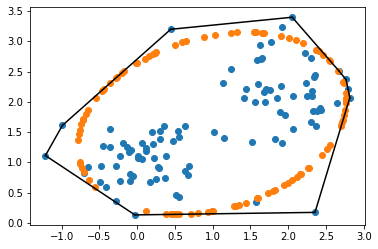

(array([[1.76696555, 0.20888852],
        [0.20888852, 1.49090543]]), array([0.98907488, 1.64734667]))

In [ ]:
#!/usr/bin/env python3

from mpl_toolkits.mplot3d import axes3d
from scipy.spatial import ConvexHull
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets

#From: https://stackoverflow.com/a/61786434/752843


def random_point_ellipse(W,d):
  # random angle
  alpha = 2 * np.pi * np.random.random()
  # vector on that angle
  pt = np.array([np.cos(alpha),np.sin(alpha)])
  #print("pt :",pt)
  # Ellipsoidize it
  return W@pt+d

def GetRandom(dims, Npts):
  if dims==2:
    centers = [[0, 1], [2, 2]]
    stds = [0.2, 0.2]
    points, labels_true = make_blobs(n_samples=100, centers=centers, cluster_std=stds, random_state=0)
  elif dims==3:
    centers = [[0, 1, 0], [1.5, 1.5, 1], [1, 3, 3]]
    stds = [0.2, 0.2, 0.2]
    points, labels_true = make_blobs(n_samples=1000, centers=centers, cluster_std=stds, random_state=0)
  else:
    raise Exception("dims must be 2 or 3!")
  noise = np.random.multivariate_normal(mean=[0]*dims, cov=0.2*np.eye(dims), size=Npts)
  return points+noise

def GetHull(points):
  dim  = points.shape[1]
  hull = ConvexHull(points)
  A    = hull.equations[:,0:dim]
  b    = hull.equations[:,dim]
  return A, -b, hull #Negative moves b to the RHS of the inequality

def Plot(points, hull, B, d):
  fig = plt.figure()
  if points.shape[1]==2:
    ax = fig.add_subplot(111)
    ax.scatter(points[:,0], points[:,1])
    for simplex in hull.simplices:
      plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    display_points = np.array([random_point_ellipse([[1,0],[0,1]],[0,0]) for i in range(100)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1])
  elif points.shape[1]==3:
    fig = plt.figure(figsize = (15, 10)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2])
    display_points = np.array([random_point_ellipse([[1,0,0],[0,1,0],[0,0,1]],[0,0,0]) for i in range(1000)])
    display_points = display_points@B+d
    ax.scatter(display_points[:,0], display_points[:,1], display_points[:,2])
  plt.show()

def FindMaximumVolumeInscribedEllipsoid(points):
  """Find the inscribed ellipsoid of maximum volume. Return its matrix-offset form."""
  dim = points.shape[1]
  A,b,hull = GetHull(points)

  B = cp.Variable((dim,dim), PSD=True) #Ellipsoid
  d = cp.Variable(dim)                 #Center

  constraints = [cp.norm(B@A[i],2)+A[i]@d<=b[i] for i in range(len(A))]
  prob = cp.Problem(cp.Minimize(-cp.log_det(B)), constraints)
  optval = prob.solve()
  if optval==np.inf:
    raise Exception("No solution possible!")
  print(f"Optimal value: {optval}") 

  Plot(points, hull, B.value, d.value)

  return B.value, d.value

FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=2, Npts=100))
#FindMaximumVolumeInscribedEllipsoid(GetRandom(dims=3, Npts=1000))

